<a href="https://colab.research.google.com/github/Medalcode/GColab/blob/main/Predictor_de_Correo_Spam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
1# Importar librerías necesarias
import os  # Para interactuar con el sistema operativo
import re  # Para expresiones regulares
import string  # Para trabajar con cadenas de texto
import nltk  # Para procesamiento de lenguaje natural
import numpy as np  # Para operaciones numéricas eficientes
import pandas as pd  # Para manipulación y análisis de datos
import matplotlib.pyplot as plt  # Para visualización de datos
import seaborn as sns  # Para visualización avanzada de datos
from sklearn.model_selection import train_test_split  # Para dividir los datos en conjuntos de entrenamiento y prueba
from sklearn.feature_extraction.text import CountVectorizer  # Para vectorizar texto
from sklearn.feature_extraction.text import TfidfVectorizer  # Para vectorizar texto con pesos TF-IDF
from sklearn.metrics import accuracy_score, classification_report  # Para evaluar el modelo
from sklearn.ensemble import RandomForestClassifier  # Para el clasificador Random Forest
from sklearn.linear_model import LogisticRegression  # Para el modelo de Regresión Logística
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix  #evaluar el rendimiento del modelo
from sklearn.pipeline import Pipeline #crea un flujo de trabajo encadenado de procesamiento y modelado en Scikit-Learn


In [ ]:

import kagglehub  # Para acceder a datasets de Kaggle
!pip install q kaggle  # Instalar la biblioteca kaggle


In [ ]:
2# Descargar el dataset y guardar la ruta en una variable
path = kagglehub.dataset_download("purusinghvi/email-spam-classification-dataset")

# Cargar el archivo CSV usando la variable `path` directamente
df = pd.read_csv(path + "/combined_data.csv")  # Asegúrate de que el nombre 'combined_data.csv' es correcto

print("Path to dataset files:", "/content/combined_data.csv")

Path to dataset files: /content/combined_data.csv


In [ ]:
3# Muestra información general del DataFrame
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83448 entries, 0 to 83447
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   83448 non-null  int64 
 1   text    83448 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


In [ ]:
4# Revisa algunos ejemplos de los datos
df.head()


,label,text,text_length
0,1,ounce feather bowl hummingbird opec moment ala...,148
1,1,wulvob medircations online qnb ikud viagra esc...,808
2,0,computer connection cnn com wednesday escapenu...,2235
3,1,university degree obtain prosperous future mon...,592
4,0,thanks answers guys know checked rsync manual ...,1362


In [ ]:
# Mostrar nombres de columnas del DataFrame
df.columns

Index(['label', 'text', 'text_length'], dtype='object')

Distribución de clases (Spam y No Spam):
 label
1    43910
0    39538
Name: count, dtype: int64

Proporción de clases:
 label
1    52.619595
0    47.380405
Name: count, dtype: float64


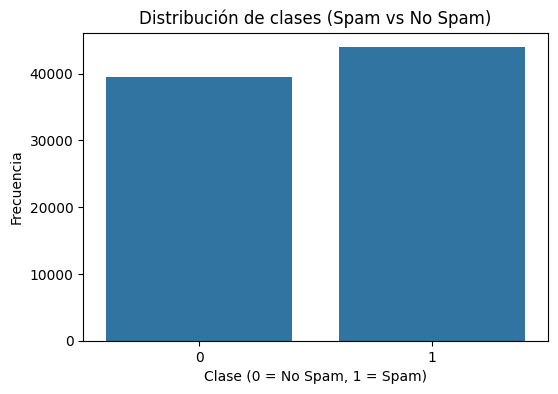

In [ ]:
# Exploración de Datos (EDA)

#5 Distribución de Clases (Spam y No Spam)
# Revisamos la distribución de las etiquetas en la columna LABEL
class_distribution = df['label'].value_counts()
print("Distribución de clases (Spam y No Spam):\n", class_distribution)
print("\nProporción de clases:\n", class_distribution / len(df) * 100)

plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df)
plt.title("Distribución de clases (Spam vs No Spam)")
plt.xlabel("Clase (0 = No Spam, 1 = Spam)")
plt.ylabel("Frecuencia")
plt.show()


In [ ]:
#6 Cantidad de Datos
# Revisamos el número total de correos electrónicos en el dataset
print("Cantidad total de correos electrónicos en el dataset:", len(df))

Cantidad total de correos electrónicos en el dataset: 83448


Longitud promedio de texto: 1235.9987537148884
Longitud mínima de texto: 0
Longitud máxima de texto: 583916


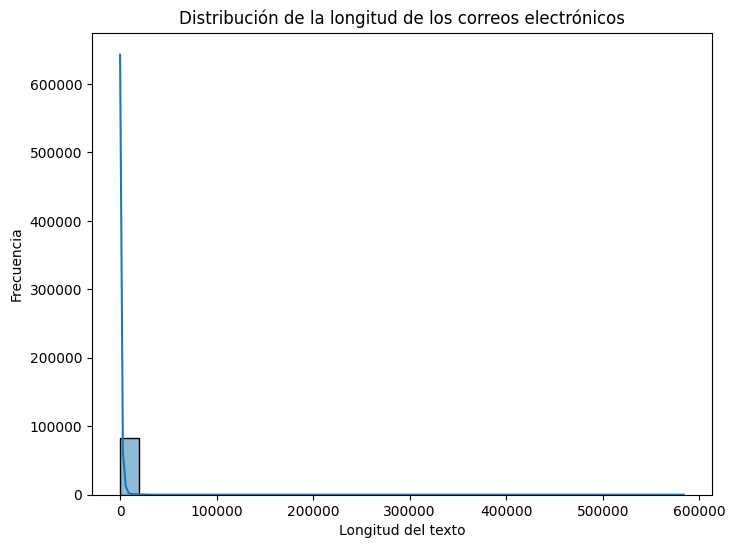

In [ ]:
#7  Formato de Texto en la Columna "Text"
# Revisamos algunas características del texto, como longitud promedio, mínima y máxima
df['text_length'] = df['text'].apply(len)
print("Longitud promedio de texto:", df['text_length'].mean())
print("Longitud mínima de texto:", df['text_length'].min())
print("Longitud máxima de texto:", df['text_length'].max())

# Visualización de la distribución de la longitud de los correos electrónicos
plt.figure(figsize=(8, 6))
sns.histplot(df['text_length'], bins=30, kde=True)
plt.title("Distribución de la longitud de los correos electrónicos")
plt.xlabel("Longitud del texto")
plt.ylabel("Frecuencia")
plt.show()

In [ ]:
#8 Transformación del Texto con TF-IDF
# Usamos TF-IDF para convertir el texto en una representación numérica
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english', max_features=3000)  # Ajusta max_features según sea necesario
X_tfidf = tfidf.fit_transform(df['text'])

# Visualizamos la forma de la matriz TF-IDF para confirmar la transformación
print("Dimensiones de la matriz TF-IDF:", X_tfidf.shape)

Dimensiones de la matriz TF-IDF: (83448, 3000)


In [ ]:
#9 Verifica si hay valores nulos
df.isnull().sum()

,0
label,0
text,0
text_length,0


In [ ]:
#10 Verifica datos duplicados
df.duplicated().sum()

1824

In [ ]:
#11 Aplicar la función de normalización al texto
df['text'] = df['text'].apply(preprocesar_texto)


In [ ]:
#12 Preprocesamiento del texto

def preprocesar_texto(texto):
    # Convertir a minúsculas
    texto = texto.lower()
    # Eliminar caracteres especiales y números
    texto = re.sub(r'\d+', '', texto)
    texto = texto.translate(str.maketrans("", "", string.punctuation))
    # Eliminar palabras comunes (stop words) en inglés
    from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
    texto = " ".join([palabra for palabra in texto.split() if palabra not in ENGLISH_STOP_WORDS])
    return texto

In [ ]:
#13 Implementación con TFIDVECTORIZER:

from sklearn.feature_extraction.text import TfidfVectorizer

# Convierte el texto en vectores TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['text'])  # Usa la columna 'text' en lugar de 'email'

# Assuming 'label' is the actual name of your target column:
y = df['label']  # Changed 'LABEL' to 'label'

In [ ]:
#14 División del conjunto de datos en entrenamiento (80%) y prueba (20%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)


Tamaño del conjunto de entrenamiento: (66758, 301242)
Tamaño del conjunto de prueba: (16690, 301242)


In [ ]:
#15 Inicialización del modelo Random Forest
random_forest_model = RandomForestClassifier(random_state=42)

#16 Entrenamiento del modelo Random Forest
random_forest_model.fit(X_train, y_train)

# Predicción y evaluación para Random Forest
rf_predictions = random_forest_model.predict(X_test)
print("Evaluación de Random Forest Classifier:")
print("Precisión:", accuracy_score(y_test, rf_predictions))
print(classification_report(y_test, rf_predictions))
print("Matriz de Confusión:\n", confusion_matrix(y_test, rf_predictions))

#17 Inicialización del modelo de Regresión Logística
logistic_regression_model = LogisticRegression(max_iter=1000, random_state=42)

#18 Entrenamiento del modelo de Regresión Logística
logistic_regression_model.fit(X_train, y_train)

# Predicción y evaluación para Logistic Regression
lr_predictions = logistic_regression_model.predict(X_test)
print("\nEvaluación de Logistic Regression:")
print("Precisión:", accuracy_score(y_test, lr_predictions))
print(classification_report(y_test, lr_predictions))
print("Matriz de Confusión:\n", confusion_matrix(y_test, lr_predictions))


Evaluación de Random Forest Classifier:
Precisión: 0.9822049131216297
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      7938
           1       0.99      0.98      0.98      8752

    accuracy                           0.98     16690
   macro avg       0.98      0.98      0.98     16690
weighted avg       0.98      0.98      0.98     16690

Matriz de Confusión:
 [[7821  117]
 [ 180 8572]]

Evaluación de Logistic Regression:
Precisión: 0.9851408028759736
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      7938
           1       0.98      0.99      0.99      8752

    accuracy                           0.99     16690
   macro avg       0.99      0.98      0.99     16690
weighted avg       0.99      0.99      0.99     16690

Matriz de Confusión:
 [[7742  196]
 [  52 8700]]


In [ ]:
#19 Crear el pipeline con el vectorizador y el modelo
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('classifier', LogisticRegression())  # Cambia LogisticRegression si prefieres otro modelo
])

# Entrenar el modelo
pipeline.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = pipeline.predict(X_test)

# Calcular la precisión y otras métricas
from sklearn.metrics import accuracy_score, classification_report

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9848412222887957
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      7938
           1       0.98      0.99      0.99      8752

    accuracy                           0.98     16690
   macro avg       0.99      0.98      0.98     16690
weighted avg       0.98      0.98      0.98     16690

